# Python Functions 
## Learn to Efficiently Process NEON Hyperspectral Data

As we learned in the previous lesson on reproducible research, automating steps whenever possible improves efficiency, reduces the chance of human-caused error, and allows yourself or others to repeat your work later on. In this lesson, we will create several functions to automate the processes we scripted in Lesson 1: Work with Hyperspectral Remote Sensing HDF5 Data. 

## Python Function Syntax
First, we need to know how to define functions in Python. Functions are defined with the following syntax:

```python
def function_name(input1, input2, optional_input3 = default_value):
	step1 
	step2
	step3 
	...
	output1 = ...
	output2 = ...
	return output1, output2
```
Note that after the function name and input arguments are defined in the first line, the following lines must be indented. The keyword "return" defines the outputs that are generated by the function. All other variables are internal to the function and will not be stored outside of the function. The function is over when the indentation ends. 
To execute the function, use the format: 
```python 
(output1, output2) = function_name(input1, input2, optional_input3)
```
Note that you can enter optional input arguments, and set them equal to the default value. In this case, if the optional argument is not entered, it will be assigned the default value. For example, you could execute the function above as follows:
(output1, output2) = function_name(input1, input2)

## Quick Guide to Commenting Functions
When writing functions, it is recommended to include a header (commented with #s) that describes the following:
1.	Purpose of the function
2.	Requirements (eg. packages/libraries that need to be imported, sub-functions, etc.) 
3.	Inputs
4.	Outputs
5.	Example of how to execute the function 
It is also recommended to comment the code throughout and/or include print statements so that it is clear what each step or chunk of the functions is doing. This will make it much easier for yourself or another user to repeat your work and achieve the same results with the same data or carry out the same analysis a different dataset. 

## Objectives 
Now that we know the syntax for generating function, we will create functions to do the following tasks: 
1.	Extract a reflectance data set from a hyperspectral hdf5 file and return the reflectance matrix dimensions
2.	Return the spatial extent of a hyperspectral hdf5 object
3.	Extract a band of a specified index # from a hyperspectral hdf5 reflectance data
4.	Apply the data ignore value and scale factor to a reflectance array, and return a properly projected reflectance raster (geotif)
5.	Plot a reflectance array, and finally
6.	Stack several bands of a reflectance dataset 

We have already done all of these tasks in Lesson 1, so now we just have to create functions to allow us to carry out these standard tasks for any NEON hdf5 hyperspectral dataset. 

In [1]:
# %load ./neon_aop.py
"""
Created on Mon Feb  6 16:36:10 2017

@author: bhass
"""

import numpy as np
import matplotlib.pyplot as plt
import h5py, gdal, osr, copy

#list_dataset lists the names of datasets in an hdf5 file
#call syntax: f.visititems(list_dataset)
def list_dataset(name,node):
    if isinstance(node, h5py.Dataset):
        print(name)

#ls_dataset displays the name, shape, and type of datasets in hdf5 file
#call syntax: f.visititems(ls_dataset)
def ls_dataset(name,node):
    if isinstance(node, h5py.Dataset):
        print(node)

def h5refl2array(refl_filename,sitename):

    hdf5_file = h5py.File(refl_filename,'r')
    refl = hdf5_file[sitename]['Reflectance']
    reflArray = refl['Reflectance_Data']
    refl_shape = reflArray.shape
    
    wavelengths = refl['Metadata']['Spectral_Data']['Wavelength']
    
    #Create metadata dictionary 
    metadata = {}
    metadata['shape'] = reflArray.shape
    metadata['mapInfo'] = refl['Metadata']['Coordinate_System']['Map_Info']
    #Extract no data value & set no data value to NaN
    metadata['noDataVal'] = float(reflArray.attrs['Data_Ignore_Value'])
    metadata['scaleFactor'] = float(reflArray.attrs['Scale_Factor'])
    
    metadata['projection'] = refl['Metadata']['Coordinate_System']['Proj4'].value
    metadata['EPSG'] = int(refl['Metadata']['Coordinate_System']['EPSG Code'].value)
    
    mapInfo = refl['Metadata']['Coordinate_System']['Map_Info'].value 
    mapInfo_string = str(mapInfo); #print('Map Info:',mapInfo_string)
    mapInfo_split = mapInfo_string.split(",")
    
    #Extract the resolution & convert to floating decimal number
    metadata['res'] = {}
    metadata['res']['pixelWidth'] = mapInfo_split[5]
    metadata['res']['pixelHeight'] = mapInfo_split[6]

    #Extract the upper left-hand corner coordinates from mapInfo
    xMin = float(mapInfo_split[3]) 
    yMax = float(mapInfo_split[4])
    #Calculate the xMax and yMin values from the dimensions
    #xMax = left corner + (# of columns * resolution)
    xMax = xMin + (refl_shape[1]*float(metadata['res']['pixelWidth']))
    yMin = yMax - (refl_shape[0]*float(metadata['res']['pixelHeight'])) 
    metadata['extent'] = (xMin,xMax,yMin,yMax)
    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = xMin
    metadata['ext_dict']['xMax'] = xMax
    metadata['ext_dict']['yMin'] = yMin
    metadata['ext_dict']['yMax'] = yMax

    return reflArray, metadata, wavelengths
    
def extract_raw_band(reflArray,reflArray_metadata,band_ind):
    bandArray = reflArray[:,:,band_ind-1].astype(np.float)
    return bandArray 

def extract_clean_band(reflArray,reflArray_metadata,band_ind):
    bandArray = reflArray[:,:,band_ind-1].astype(np.float)
    bandCleaned = copy.copy(bandArray)
    bandCleaned[bandCleaned==int(reflArray_metadata['noDataVal'])]=np.nan
    bandCleaned = bandCleaned/reflArray_metadata['scaleFactor']
    return bandCleaned   

def plot_band_array(band_array,refl_extent,size=(6,6),title='',cmap_title='',colormap='spectral'):
    fig = plt.figure(figsize=size)
    plot = plt.imshow(band_array,extent=refl_extent); 
    cbar = plt.colorbar(plot,aspect=40); plt.set_cmap(colormap); 
    cbar.set_label(cmap_title,rotation=90,labelpad=20)
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation #
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

def array2raster(newRaster,reflBandArray,reflArray_metadata,epsg): 
    cols = reflBandArray.shape[1]
    rows = reflBandArray.shape[0]
    pixelWidth = float(reflArray_metadata['res']['pixelWidth'])
    pixelHeight = -float(reflArray_metadata['res']['pixelHeight'])
    originX = reflArray_metadata['ext_dict']['xMin']
    originY = reflArray_metadata['ext_dict']['yMax']
    
    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create('hopb_b56.tif', cols, rows, 1, gdal.GDT_Byte)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(reflBandArray)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(epsg) #4326 = WGS84
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

def calc_clip_index(clipExtent, h5Extent, xscale=1, yscale=1):
    #Define a dictionary for the index extent (ind_ext):
    
    h5rows = h5Extent['yMax'] - h5Extent['yMin']
    h5cols = h5Extent['xMax'] - h5Extent['xMin']    
    
    ind_ext = {}
    ind_ext['xMin'] = round((clipExtent['xMin']-h5Extent['xMin'])/xscale)
    ind_ext['xMax'] = round((clipExtent['xMax']-h5Extent['xMin'])/xscale)
    ind_ext['yMax'] = round(h5rows - (clipExtent['yMin']-h5Extent['yMin'])/xscale)
    ind_ext['yMin'] = round(h5rows - (clipExtent['yMax']-h5Extent['yMin'])/yscale)
#     ind_ext['yMin'] = round((clipExtent['yMin']-h5Extent['yMin'])/xscale)
#     ind_ext['yMax'] = round((clipExtent['yMax']-h5Extent['yMin'])/yscale)

    #print(sub_ext['yMin'])
    #xmin.index = round((clipExtent@xmin- h5Extent@xmin)/xscale)}
    return ind_ext

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Read in SERC Reflectance Data as an Array

In [3]:
sercRefl, sercRefl_md, wavelengths = h5refl2array('../data/SERC/hyperspectral/NEON_D02_SERC_DP1_20160807_160559_reflectance.h5','SERC')

for item in sorted(sercRefl_md):
    print(item + ':',sercRefl_md[item])

EPSG: 32618
ext_dict: {'xMax': 368273.0, 'yMin': 4300128.0, 'yMax': 4310980.0, 'xMin': 367167.0}
extent: (367167.0, 368273.0, 4300128.0, 4310980.0)
mapInfo: <HDF5 dataset "Map_Info": shape (), type "|O">
noDataVal: -9999.0
projection: b'+proj=UTM +zone= 18 +ellps= WGS-84 +datum= WGS-84 +units= units=Meters +no_defs'
res: {'pixelWidth': ' 1.0000000000e+000', 'pixelHeight': ' 1.0000000000e+000'}
scaleFactor: 10000.0
shape: (10852, 1106, 426)


## Stack Bands
It is often useful to look at several bands together. As you recall from the introductory video, a stack of three bands in the red, green, and blue (RGB) spectrums produces a color image that looks similar to what we see in person. In the next part of this tutorial, we will learn to stack multiple bands and make a geotif raster from the compilation of these bands. We can see that different combinations of bands allow for different visualizations of the remotely-sensed objects and also convey different information about the objects' chemical makeup. 

In [4]:
#Extract Multiple Bands and Stack
bands = (58,34,19)
print('bands:',bands)
print('length of bands:',len(bands))

bands: (58, 34, 19)
length of bands: 3


In [5]:
print('Band 58 Center Wavelength = %.2f' %(wavelengths.value[57]),'nm')
print('Band 34 Center Wavelength = %.2f' %(wavelengths.value[33]),'nm')
print('Band 19 Center Wavelength = %.2f' %(wavelengths.value[18]),'nm')

Band 58 Center Wavelength = 669.10 nm
Band 34 Center Wavelength = 548.91 nm
Band 19 Center Wavelength = 473.80 nm


## `Python Dictionary`
To stack the bands, we will create a dictionary, which in `Python` is as a list of unordered key value pairs. 

In [6]:
band_dict = {}
band_names = []
for i in range(len(bands)):
    band_names.append("b" + str(bands[i]))
    band_dict[band_names[i]] = extract_clean_band(sercRefl,sercRefl_md,bands[i])  

Band 58 Stats: min= 0.0 , max= 1.6 , mean: 0.03
Band 34 Stats: min= 0.0 , max= 1.61 , mean: 0.04
Band 19 Stats: min= 0.0 , max= 1.68 , mean: 0.02


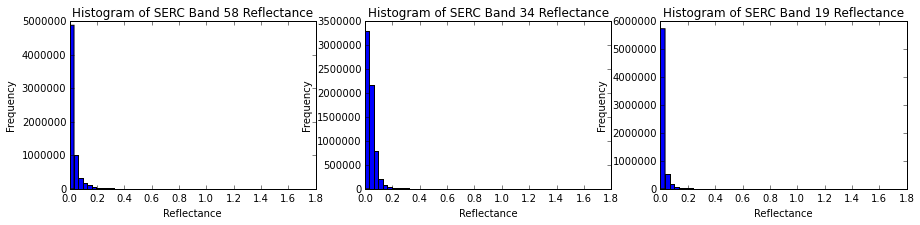

In [7]:
print('Band 58 Stats: min=',np.nanmin(band_dict['b58']),', max=',round(np.nanmax(band_dict['b58']),2),', mean:',round(np.nanmean(band_dict['b58']),2))

fig = plt.figure(figsize=(15,3))
ax1 = fig.add_subplot(1,3,1)
plt.hist(band_dict['b58'][~np.isnan(band_dict['b58'])],50);
plt.title('Histogram of SERC Band 58 Reflectance')
plt.xlabel('Reflectance'); plt.ylabel('Frequency')

print('Band 34 Stats: min=',np.nanmin(band_dict['b34']),', max=',round(np.nanmax(band_dict['b34']),2),', mean:',round(np.nanmean(band_dict['b34']),2))
ax2 = fig.add_subplot(1,3,2)
plt.hist(band_dict['b34'][~np.isnan(band_dict['b34'])],50);
plt.title('Histogram of SERC Band 34 Reflectance')
plt.xlabel('Reflectance'); plt.ylabel('Frequency')

print('Band 19 Stats: min=',np.nanmin(band_dict['b19']),', max=',round(np.nanmax(band_dict['b19']),2),', mean:',round(np.nanmean(band_dict['b19']),2))
ax3 = fig.add_subplot(1,3,3)
plt.hist(band_dict['b19'][~np.isnan(band_dict['b19'])],50);
plt.title('Histogram of SERC Band 19 Reflectance')
plt.xlabel('Reflectance'); plt.ylabel('Frequency')

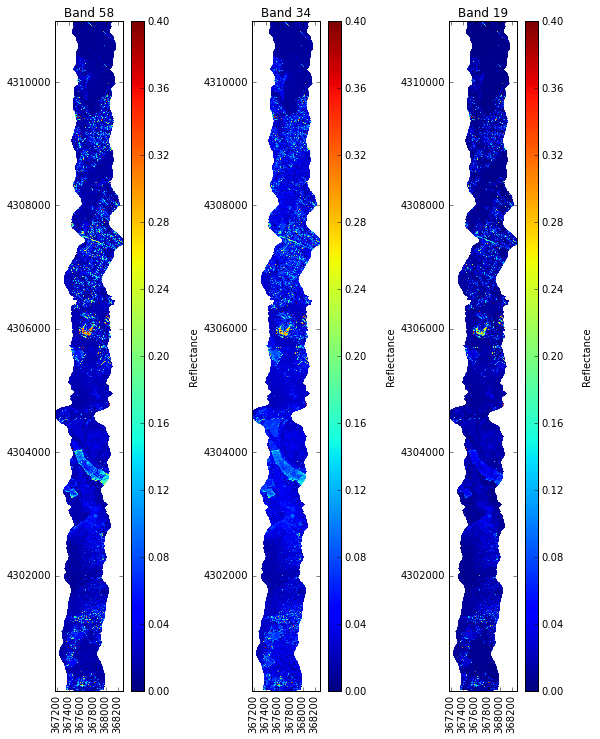

In [8]:
colormap='jet'; cmap_title='Reflectance'; max_refl=0.4;

# plot_band_array(band_dict['b58'],sercRefl_md['extent'],size=(10,10),title='SERC Band 58',cmap_title='Reflectance')
fig = plt.figure(figsize=(10,12));
ax1 = fig.add_subplot(1,3,1)
plot = plt.imshow(band_dict['b58'],extent=sercRefl_md['extent'],clim=(0,max_refl)); 
cbar = plt.colorbar(plot,aspect=50); plt.set_cmap(colormap); 
cbar.set_label(cmap_title,rotation=90,labelpad=20)
plt.title('Band 58'); 
ax1.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation #
rotatexlabels = plt.setp(ax1.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

ax2 = fig.add_subplot(1,3,2)
plot = plt.imshow(band_dict['b34'],extent=sercRefl_md['extent'],clim=(0,max_refl)); 
cbar = plt.colorbar(plot,aspect=50); plt.set_cmap(colormap); 
cbar.set_label(cmap_title,rotation=90,labelpad=20)
plt.title('Band 34');  
ax2.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation #
rotatexlabels = plt.setp(ax2.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

ax3 = fig.add_subplot(1,3,3)
plot = plt.imshow(band_dict['b19'],extent=sercRefl_md['extent'],clim=(0,max_refl)); 
cbar = plt.colorbar(plot,aspect=50); plt.set_cmap(colormap); 
cbar.set_label(cmap_title,rotation=90,labelpad=20)
plt.title('Band 19'); 
ax3.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation #
rotatexlabels = plt.setp(ax3.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

## Subset Data

{'xMax': 933, 'yMax': 5230, 'xMin': 233, 'yMin': 4630}
SERC Reflectance Subset Shape: (600, 700, 426)


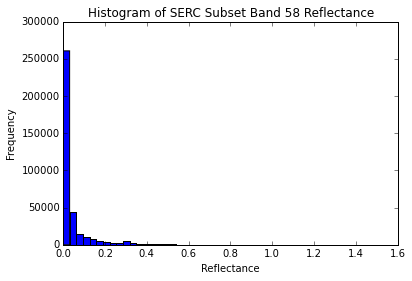

In [9]:
clipExtent = {}
clipExtent['xMin'] = 367400.
clipExtent['xMax'] = 368100.
clipExtent['yMin'] = 4305750.
clipExtent['yMax'] = 4306350.

clipExt = (clipExtent['xMin'],clipExtent['xMax'],clipExtent['yMin'],clipExtent['yMax'])

serc_subInd = calc_clip_index(clipExtent,sercRefl_md['ext_dict'])
print(serc_subInd)

serc_subArray = sercRefl[serc_subInd['yMin']:serc_subInd['yMax'],serc_subInd['xMin']:serc_subInd['xMax'],:]
serc_subExt = (clipExtent['xMin'],clipExtent['xMax'],clipExtent['yMin'],clipExtent['yMax'])
print('SERC Reflectance Subset Shape:',serc_subArray.shape)

serc_b58_subset = serc_subArray[:,:,57].astype(np.float)
serc_b58_subset[serc_b58_subset==int(sercRefl_md['noDataVal'])]=np.nan
serc_b58_subset = serc_b58_subset/sercRefl_md['scaleFactor']

plt.hist(serc_b58_subset[~np.isnan(serc_b58_subset)],50);
plt.title('Histogram of SERC Subset Band 58 Reflectance')
plt.xlabel('Reflectance'); plt.ylabel('Frequency')

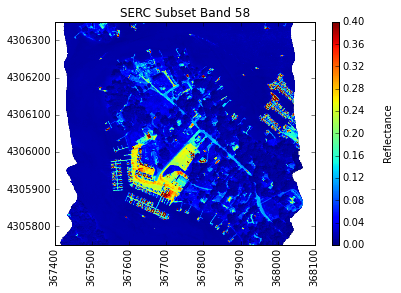

In [10]:
# plot_band_array(serc_b56_subset,clipExt,size=(6,6),title='SERC Subset - Band 56 ',cmap_title='Reflectance',colormap='spectral')
# ax1 = fig.add_subplot(1,1,1)
plt.imshow(serc_b58_subset,extent=clipExt,clim=(0,.5)); 
cbar = plt.colorbar(plot,aspect=30); plt.set_cmap(colormap); 
cbar.set_label(cmap_title,rotation=90,labelpad=20)
plt.title('SERC Subset Band 58'); ax = plt.gca()
ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation #
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

In [12]:
def clean_band(bandArray,reflArray_metadata):
    band_clean = copy.copy(bandArray)
    band_clean[band_clean==int(reflArray_metadata['noDataVal'])]=np.nan
    band_clean = band_clean/reflArray_metadata['scaleFactor']
    return band_clean

In [13]:
serc_b58_subset = serc_subArray[:,:,57].astype(np.float)
serc_b58_subset_clean = clean_band(serc_b58_subset,sercRefl_md)
print('Band 58 Stats: min=',np.nanmin(serc_b58_subset_clean),', max=',round(np.nanmax(serc_b58_subset_clean),2),
      ', mean=',round(np.nanmean(serc_b58_subset_clean),2))

serc_b34_subset = serc_subArray[:,:,33].astype(np.float)
serc_b34_subset_clean = clean_band(serc_b34_subset,sercRefl_md)
print('Band 34 Stats: min=',np.nanmin(serc_b34_subset_clean),', max=',round(np.nanmax(serc_b34_subset_clean),2),
      ', mean=',round(np.nanmean(serc_b34_subset_clean),2))

serc_b19_subset = serc_subArray[:,:,18].astype(np.float)
serc_b19_subset_clean = clean_band(serc_b19_subset,sercRefl_md)
print('Band 19 Stats: min=',np.nanmin(serc_b19_subset_clean),', max=',round(np.nanmax(serc_b19_subset_clean),2),
      ', mean=',round(np.nanmean(serc_b19_subset_clean),2))

Band 58 Stats: min= 0.0 , max= 1.59 , mean= 0.05
Band 34 Stats: min= 0.0 , max= 1.33 , mean= 0.06
Band 19 Stats: min= 0.0 , max= 1.21 , mean= 0.03


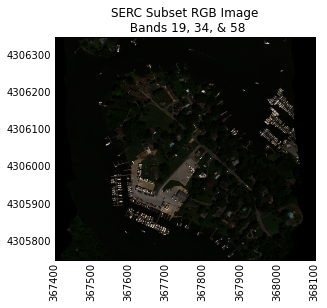

In [14]:
from PIL import Image
#import numpy as np
rgbArray = np.zeros((serc_subArray.shape[0],serc_subArray.shape[1],len(bands)), 'uint8')
rgbArray[..., 0] = serc_b58_subset_clean*256
rgbArray[..., 1] = serc_b34_subset_clean*256
rgbArray[..., 2] = serc_b19_subset_clean*256

# plot_band_array(rgbArray,clipExt,title='SERC Subset - Bands 19, 34, 58',cmap_title='Reflectance')

plot = plt.imshow(rgbArray,extent=clipExt); 
#cbar = plt.colorbar(plot,aspect=20); plt.set_cmap(colormap); 
#cbar.set_label(cmap_title,rotation=90,labelpad=20)
plt.title('SERC Subset RGB Image \n Bands 19, 34, & 58'); ax = plt.gca(); 
ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

This image is pretty dark, making it difficult to distinguish between water & land and some of the more subtle features. We can look at the histograms of the bands and limit the colorbar in order to stretch the visual contrast of the image. 

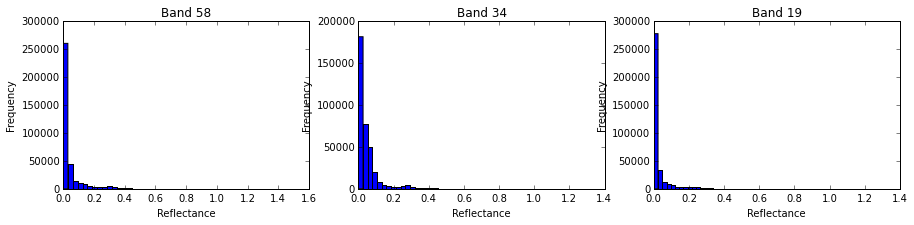

In [15]:
#Plot histograms of each band to determine ranges of data to enhance visual contrast: 
fig = plt.figure(figsize=(15,3));
ax1 = fig.add_subplot(1,3,1)
plt.hist(serc_b58_subset_clean[~np.isnan(serc_b58_subset_clean)],50);
plt.title('Band 58'); plt.xlabel('Reflectance'); plt.ylabel('Frequency')

ax2 = fig.add_subplot(1,3,2)
plt.hist(serc_b34_subset_clean[~np.isnan(serc_b34_subset_clean)],50);
plt.title('Band 34'); plt.xlabel('Reflectance'); plt.ylabel('Frequency')

ax3 = fig.add_subplot(1,3,3)
plt.hist(serc_b19_subset_clean[~np.isnan(serc_b34_subset_clean)],50);
plt.title('Band 19'); plt.xlabel('Reflectance'); plt.ylabel('Frequency')

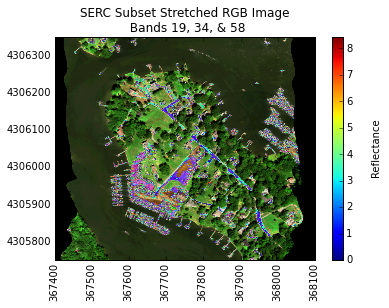

In [16]:
plot = plt.imshow(rgbArray/30,extent=clipExt) #,clim=(0,.5)); 
cbar = plt.colorbar(plot,aspect=20); plt.set_cmap(colormap); 
cbar.set_label(cmap_title,rotation=90,labelpad=20)
plt.title('SERC Subset Stretched RGB Image \n Bands 19, 34, & 58'); ax = plt.gca(); 
ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

## Interactive Plot Widget

<function __main__.RGBplot>

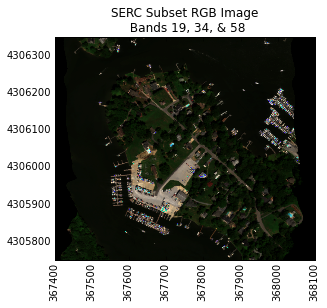

In [17]:
from IPython.html.widgets import *

def RGBplot(stretch):
    plot = plt.imshow(rgbArray/(256-stretch*256/100),extent=clipExt); 
    plt.title('SERC Subset RGB Image \n Bands 19, 34, & 58'); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees
    
interact(RGBplot, stretch=(0,100,1))

## False Color Image
We can also create an image from bands outside of the visible spectrum. An image containing one or more bands outside of the visible range is called a **false-color image**.

Band 363 Center Wavelength = 2196.45 nm
Band 246 Center Wavelength = 1610.55 nm
Band 58 Center Wavelength = 669.10 nm


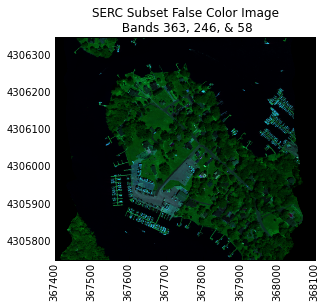

In [18]:
bands363_246_58 = (363,246,58)

print('Band 363 Center Wavelength = %.2f' %(wavelengths.value[362]),'nm')
print('Band 246 Center Wavelength = %.2f' %(wavelengths.value[245]),'nm')
print('Band 58 Center Wavelength = %.2f' %(wavelengths.value[57]),'nm')

serc_b363_subset = serc_subArray[:,:,0].astype(np.float)
serc_b363_subset_clean = clean_band(serc_b363_subset,sercRefl_md)

serc_b246_subset = serc_subArray[:,:,245].astype(np.float)
serc_b246_subset_clean = clean_band(serc_b246_subset,sercRefl_md)

serc_b58_subset = serc_subArray[:,:,57].astype(np.float)
serc_b58_subset_clean = clean_band(serc_b58_subset,sercRefl_md)

rgbArray363_246_58 = np.zeros((serc_subArray.shape[0],serc_subArray.shape[1],len(bands363_246_58)), 'uint8')
rgbArray363_246_58[..., 0] = serc_b363_subset_clean*256
rgbArray363_246_58[..., 1] = serc_b246_subset_clean*256
rgbArray363_246_58[..., 2] = serc_b58_subset_clean*256

# plot_band_array(rgbArray,clipExt,title='SERC Subset - Bands 19, 34, 58',cmap_title='Reflectance')

plot = plt.imshow(rgbArray363_246_58,extent=clipExt); 
plt.title('SERC Subset False Color Image\n Bands 363, 246, & 58'); ax = plt.gca(); 
ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

## Color Infrared (CIR) Image
We can also make an infrared image, where we will use the same Green and Blue bands as in our RGB arrays but instead of using a band in the Red portion of the visible spectrum, we'll use a band in the Infrared range: 

In [19]:
CIR_bands = (90,34,19)
print('Band 90 Center Wavelength = %.2f' %(wavelengths.value[89]),'nm')
print('Band 34 Center Wavelength = %.2f' %(wavelengths.value[33]),'nm')
print('Band 19 Center Wavelength = %.2f' %(wavelengths.value[18]),'nm')

Band 90 Center Wavelength = 829.34 nm
Band 34 Center Wavelength = 548.91 nm
Band 19 Center Wavelength = 473.80 nm


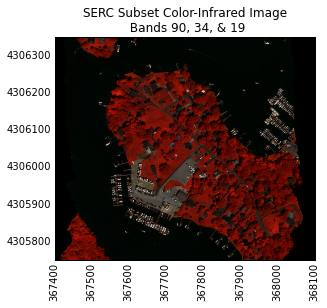

In [20]:
serc_b90_subset = serc_subArray[:,:,89].astype(np.float)
serc_b90_subset_clean = clean_band(serc_b90_subset,sercRefl_md)

# Bands 34 & 19 were previously defined while creating the RGB array

rgbArray90_34_19 = np.zeros((serc_subArray.shape[0],serc_subArray.shape[1],3), 'uint8')
rgbArray90_34_19[..., 0] = serc_b90_subset_clean*256
rgbArray90_34_19[..., 1] = serc_b34_subset_clean*256
rgbArray90_34_19[..., 2] = serc_b19_subset_clean*256

# plot_band_array(rgbArray,clipExt,title='SERC Subset - Bands 19, 34, 58',cmap_title='Reflectance')

plot = plt.imshow(rgbArray90_34_19,extent=clipExt); 
plt.title('SERC Subset Color-Infrared Image\n Bands 90, 34, & 19'); ax = plt.gca(); 
ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

## Try out Different RGB Band Combinations Interactively

<function __main__.RGBplot>

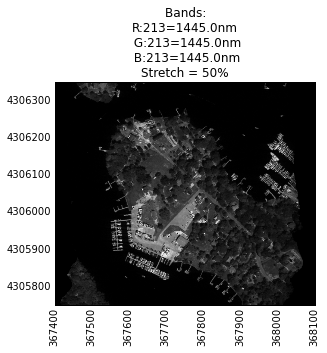

In [21]:
from IPython.html.widgets import *

array = copy.copy(serc_subArray)
Refl_md = copy.copy(sercRefl_md)


def RGBplot(R,G,B,stretch):
    rgbArray = np.zeros((serc_subArray.shape[0],serc_subArray.shape[1],3), 'uint8')
    
    Rband = array[:,:,R-1].astype(np.float)
    Rband_clean = clean_band(Rband,Refl_md)
    
    Gband = array[:,:,G-1].astype(np.float)
    Gband_clean = clean_band(Gband,Refl_md)
    
    Bband = array[:,:,B-1].astype(np.float)
    Bband_clean = clean_band(Bband,Refl_md)
    
    rgbArray[..., 0] = Rband_clean*256
    rgbArray[..., 1] = Gband_clean*256
    rgbArray[..., 2] = Bband_clean*256
    
    plot = plt.imshow(rgbArray/(256-stretch*256/100),extent=clipExt); 
    plt.title('Bands: \nR:' + str(R) + '=' + str(round(wavelengths.value[R-1])) +'nm'
              + '\n G:' + str(G) + '=' + str(round(wavelengths.value[G-1])) + 'nm'
              + '\n B:' + str(B) + '=' + str(round(wavelengths.value[B-1])) + 'nm'
              + '\nStretch = ' + str(stretch) + '%'); 
    ax = plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees
    
interact(RGBplot, R=(1,426,1), G=(1,426,1), B=(1,426,1), stretch=(0,100,1))

## Function to Stack Bands (Complete Reflectance Extent)

In [22]:
#stack_band creates a stacked array of bands from a reflectance matrix, and optionally clips to a specified subset extent
# Inputs:
#  1. reflArray: reflectance array, containing 426 bands (note: can subset)
#  2. bands: list of bands to be extracted, each band # must be between 1-426 (# of bands in NEON AOP data). eg. bands = (100,200,300)
# Output: Stacked array of specified bands
# Dependencies: 
# 1. reflArray and reflArray_metadata are generated from AOP metadata with the function h5refl2array.py 
# 2. calc_clip_index.py is used for subsetting, if specified 

def stack_bands(reflArray,reflArray_metadata,bands):
    band_clean_dict = {}
    band_clean_names = []

    stackedArray = np.zeros((reflArray.shape[0],reflArray.shape[1],len(bands)),'uint8') #pre-allocate stackedArray matrix
    
    for i in range(len(bands)):
        band_clean_names.append("b"+str(bands[i])+"_refl_clean")
        band_clean_dict[band_clean_names[i]] = extract_clean_band(reflArray,reflArray_metadata,bands[i])
        stackedArray[...,i] = band_clean_dict[band_clean_names[i]]*256
                        
    return stackedArray

## Test out `stack_bands` function

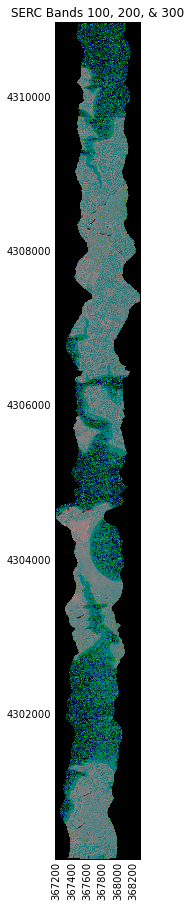

In [23]:
serc_rgbArray100_200_300 = stack_bands(sercRefl,sercRefl_md,(100,200,300))
# print(rgbArray.shape)

fig = plt.figure(figsize=(15,15))
plot = plt.imshow(serc_rgbArray100_200_300,extent=sercRefl_md['extent']); 
plt.title('SERC Bands 100, 200, & 300'); ax = plt.gca(); 
ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

## Subset Bands & Stack 

In [25]:
def subset_clean_band(reflArray,reflArray_metadata,clipIndex,bandIndex):
    bandCleaned = reflArray[clipIndex['yMin']:clipIndex['yMax'],clipIndex['xMin']:clipIndex['xMax'],bandIndex-1].astype(np.float)
    bandCleaned[bandCleaned==int(reflArray_metadata['noDataVal'])]=np.nan
    bandCleaned = bandCleaned/reflArray_metadata['scaleFactor']
    return bandCleaned 

#clipIndex = calc_clip_index(clipExtent, h5Extent)

In [26]:
def stack_subset_bands(reflArray,reflArray_metadata,bands,clipIndex):
    band_clean_dict = {}
    band_clean_names = []

    subArray_rows = clipIndex['yMax'] - clipIndex['yMin']
    subArray_cols = clipIndex['xMax'] - clipIndex['xMin']
    
    stackedArray = np.zeros((subArray_rows,subArray_cols,len(bands)),'uint8') #pre-allocate stackedArray matrix
    
    for i in range(len(bands)):
        band_clean_names.append("b"+str(bands[i])+"_refl_clean")
        band_clean_dict[band_clean_names[i]] = subset_clean_band(reflArray,reflArray_metadata,clipIndex,bands[i])
        stackedArray[...,i] = band_clean_dict[band_clean_names[i]]*256
                        
    return stackedArray

## Test out `subset_clean_band` and `stack_subset_bands` functions

In [27]:
clipIndex = calc_clip_index(clipExtent,sercRefl_md['ext_dict'])
print('SERC Subset Extent Dictionary:',clipExtent)
print('SERC Subset Extent:',clipExt)
print('SERC Subset Index:',clipIndex)

serc_subset_b1 = subset_clean_band(sercRefl,sercRefl_md,clipIndex,1)
print('SERC subsetted band shape:',serc_subset_b1.shape)
# bandCleaned = sercRefl[clipIndex['xMin']:clipIndex['xMax'],clipIndex['yMin']:clipIndex['yMax'],1-1].astype(np.float)

{'xMax': 368100.0, 'yMin': 4305750.0, 'yMax': 4306350.0, 'xMin': 367400.0}
(367400.0, 368100.0, 4305750.0, 4306350.0)
{'xMax': 933, 'yMax': 5230, 'xMin': 233, 'yMin': 4630}
(600, 700)


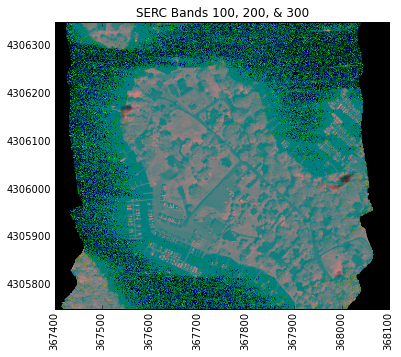

In [28]:
sercSubsetStack100_200_300 = stack_subset_bands(sercRefl,sercRefl_md,(100,200,300),clipIndex)

fig = plt.figure(figsize=(6,6))
plot = plt.imshow(sercSubsetStack100_200_300,extent=clipExt); 
plt.title('SERC Bands 100, 200, & 300'); ax = plt.gca(); 
ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees